Classifying ImageNet: the instant Caffe way
===========================================

Caffe has a Python interface, pycaffe, with a `caffe.Net` interface for models. There are both Python and MATLAB interfaces. While this example uses the off-the-shelf Python `caffe.Classifier` interface there is also a MATLAB example at `matlab/caffe/matcaffe_demo.m`.

Before we begin, you must compile Caffe. You should add the Caffe module to your `PYTHONPATH` although this example includes it automatically. If you haven't yet done so, please refer to the [installation instructions](http://caffe.berkeleyvision.org/installation.html). This example uses our pre-trained CaffeNet model, an ILSVRC12 image classifier. You can download it by running `./scripts/download_model_binary.py models/bvlc_reference_caffenet` or let the first step of this example download it for you.

Ready? Let's start.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = '../models/bvlc_reference_caffenet/deploy.prototxt'
PRETRAINED = '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
IMAGE_FILE = 'images/cat.jpg'

import os
if not os.path.isfile(PRETRAINED):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

...100%, 232 MB, 349 KB/s, 681 seconds passed

Loading a network is easy. `caffe.Classifier` takes care of everything. Note the arguments for configuring input preprocessing: mean subtraction switched on by giving a mean array, input channel swapping takes care of mapping RGB into the reference ImageNet model's BGR order, and raw scaling multiplies the feature scale from the input [0,1] to the ImageNet model's [0,255].

We will set the phase to test since we are doing testing, and will first use CPU for the computation.

In [2]:
caffe.set_mode_cpu()
net = caffe.Classifier(MODEL_FILE, PRETRAINED,
                       mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

Let's take a look at our example image with Caffe's image loading helper.

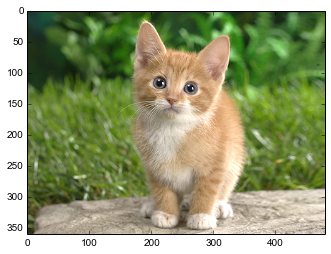

In [3]:
input_image = caffe.io.load_image(IMAGE_FILE)
plt.imshow(input_image)

Time to classify. The default is to actually do 10 predictions, cropping the center and corners of the image as well as their mirrored versions, and average over the predictions:

prediction shape: (1000,)
predicted class: 281


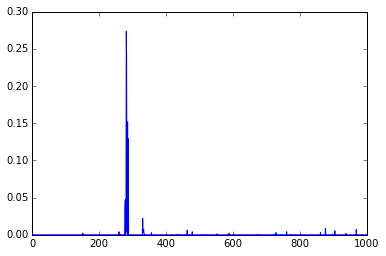

In [29]:
prediction = net.predict([input_image])  # predict takes any number of images, and formats them for the Caffe net automatically
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax()

You can see that the prediction is 1000-dimensional, and is pretty sparse.

The predicted class 281 is "Tabby cat." Our pretrained model uses the synset ID ordering of the classes, as listed in `../data/ilsvrc12/synset_words.txt` if you fetch the auxiliary imagenet data by `../data/ilsvrc12/get_ilsvrc_aux.sh`. If you look at the top indices that maximize the prediction score, they are cats, foxes, and other cute mammals. Not unreasonable predictions, right?

Now let's classify by the center crop alone by turning off oversampling. Note that this makes a single input, although if you inspect the model definition prototxt you'll see the network has a batch size of 10. The python wrapper handles batching and padding for you!

prediction shape: (1000,)
predicted class: 281


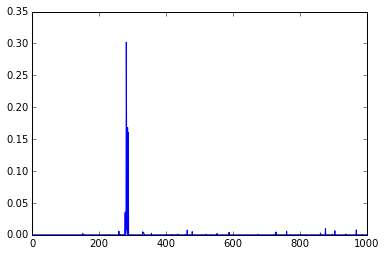

In [30]:
prediction = net.predict([input_image], oversample=False)
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])
print 'predicted class:', prediction[0].argmax()



Now, why don't we see how long it takes to perform the classification end to end? This result is run from an Intel i5 CPU, so you may observe some performance differences.

In [31]:
%timeit net.predict([input_image])

1 loops, best of 3: 1.34 s per loop


It may look a little slow, but note that time is spent on cropping, python interfacing, and running 10 images. For performance, if you really want to make prediction fast, you can optionally code in C++ and pipeline operations better. For experimenting and prototyping the current speed is fine.

Let's time classifying a single image with input preprocessed:

In [32]:
# Resize the image to the standard (256, 256) and oversample net input sized crops.
input_oversampled = caffe.io.oversample([caffe.io.resize_image(input_image, net.image_dims)], net.crop_dims)
# 'data' is the input blob name in the model definition, so we preprocess for that input.
caffe_input = np.asarray([net.transformer.preprocess('data', in_) for in_ in input_oversampled])
# forward() takes keyword args for the input blobs with preprocessed input arrays.
%timeit net.forward(data=caffe_input)

1 loops, best of 3: 1.29 s per loop


OK, so how about GPU? it is actually pretty easy:

In [33]:
caffe.set_mode_gpu()

Voila! Now we are in GPU mode. Let's see if the code gives the same result:

prediction shape: (1000,)


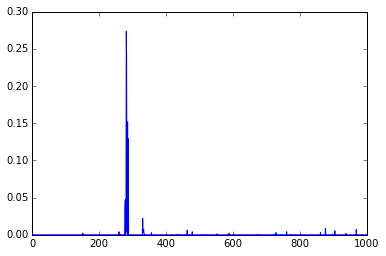

In [34]:
prediction = net.predict([input_image])
print 'prediction shape:', prediction[0].shape
plt.plot(prediction[0])

Good, everything is the same. And how about time consumption? The following benchmark is obtained on the same machine with a GTX 770 GPU:

In [35]:
# Full pipeline timing.
%timeit net.predict([input_image])

10 loops, best of 3: 87.1 ms per loop


In [36]:
# Forward pass timing.
%timeit net.forward(data=caffe_input)

10 loops, best of 3: 47.9 ms per loop


Pretty fast right? Not as fast as you expected? Indeed, in this python demo you are seeing only 4 times speedup. But remember - the GPU code is actually very fast, and the data loading, transformation and interfacing actually start to take **more** time than the actual conv. net computation itself!

To fully utilize the power of GPUs, you really want to:

* Use larger batches, and minimize python call and data transfer overheads.
* Pipeline data load operations, like using a subprocess.
* Code in C++. A little inconvenient, but maybe worth it if your dataset is really, really large.

Parting Words
-------------

So this is python! We hope the interface is easy enough for one to use. The python wrapper is interfaced with boost::python, and source code can be found at `python/caffe` with the main interface in `pycaffe.py` and the classification wrapper in `classifier.py`. If you have customizations to make, start there! Do let us know if you make improvements by sending a pull request!